# Introduction to Copulas in R
Some experiments to introduce the idea of copulas and the functions for working with them in R.


In [1]:
suppressMessages(library(here))
library(ggplot2)
suppressMessages(library(GGally, warn.conflicts=FALSE))
library(copula)

source(here('R', 'example-data.R'), echo=FALSE)
source(here('R', 'plots.R'), echo=FALSE)

## Some motivating examples
Consider the following two bivariate datasets.  What can we say about the association between the two variables in each dataset?

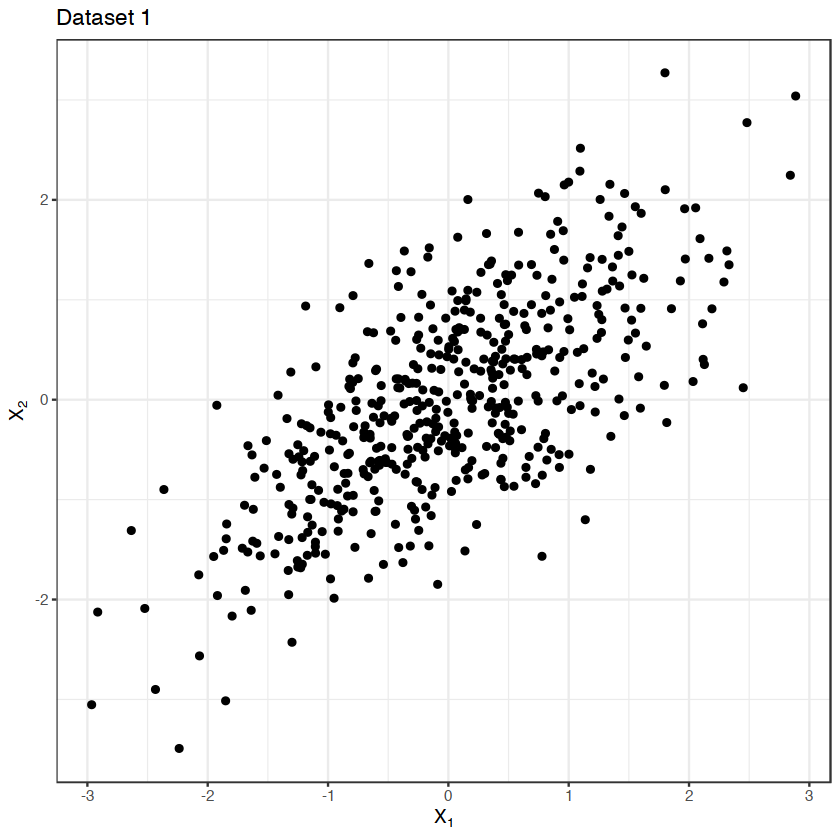

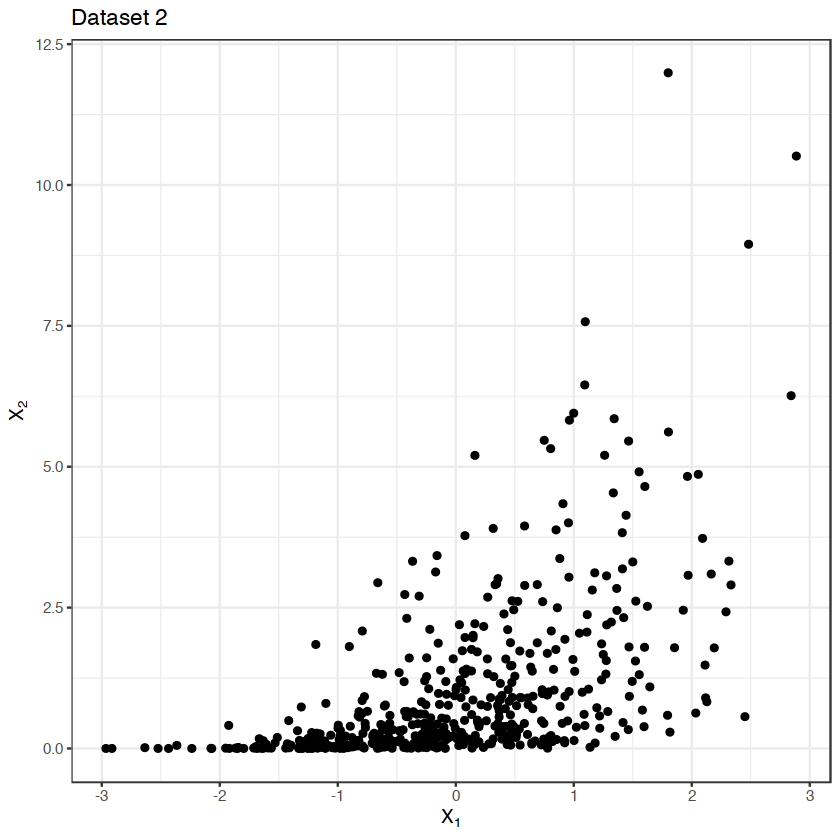

In [2]:
set.seed(867-5309)
examp_data <- exampdata_2d()
scatterplot_mat(examp_data$X1) + ggtitle('Dataset 1')
scatterplot_mat(examp_data$X2) + ggtitle('Dataset 2')

At a glance the two datasets seem wildly different, but it's hard to tell because the marginal distributions are very different ($X_2$ in Dataset 2 is restricted to being positive, for one thing).  If we look at the Kendall's tau statistic for the two datasets, that gives us our first clue that something is up.

In [3]:
cor(examp_data$X1, method='kendall')
cor(examp_data$X2, method='kendall')

1.0000000,0.4741162
0.4741162,1.0000000


1.0000000,0.4741162
0.4741162,1.0000000


The correlation (as measured by $\tau$) is identical, indicating that these two datasets have something fundamental in common, but it is being obscured.  In fact, they are the same dataset, but in the second case the $X_2$ variable has been transformed to a different margin.

We can investigate the underlying structure of the relationship between the two variables by transforming each variable to a standard uniform marginal distribution.  The joint distribution that you get by doing this is called the _copula_ of the distribution.

Ordinarily, when presented with a distribution like this, we wouldn't know what the true marginal distributions of the variables are, but in this case we picked the marginals when we generated the data, so we know that all of the variables are standard normal, except for $X_2$ in Dataset 2, which is a $\chi^2$ with one degree of freedom.

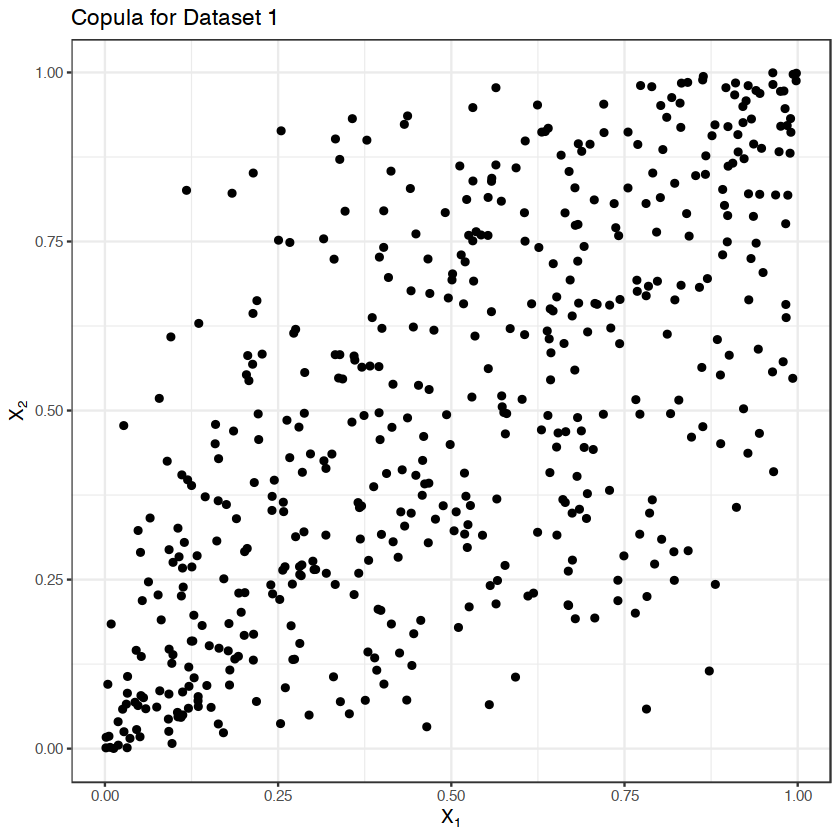

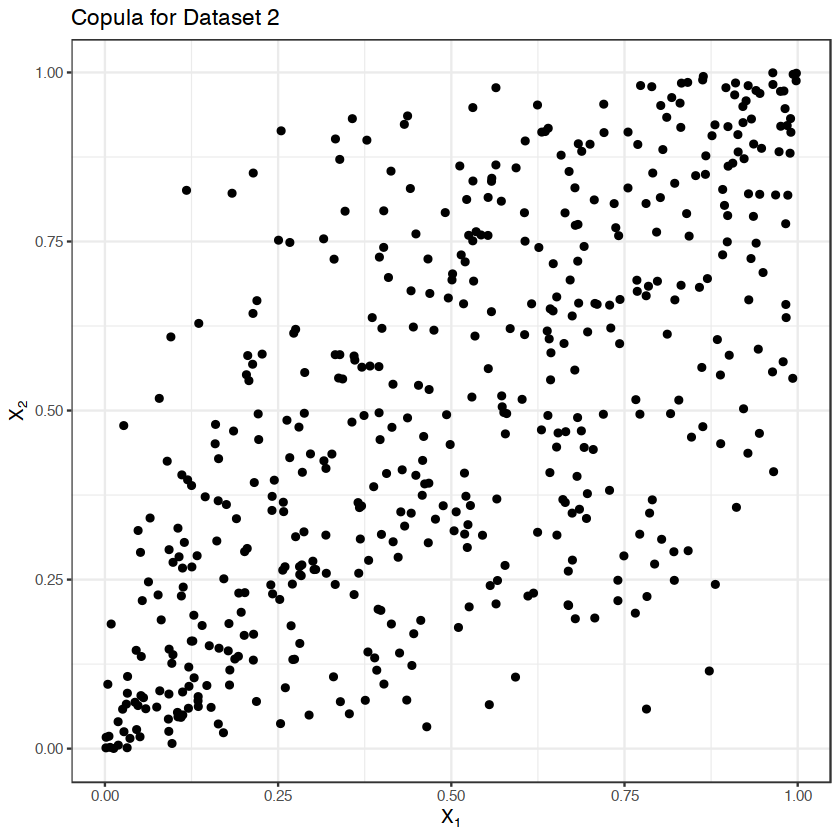

In [4]:
u1 <- pnorm(examp_data$X1)
u2 <- pnorm(examp_data$X2); u2[,2] <- pchisq(examp_data$X2[,2], df=1)
scatterplot_mat(u1) + ggtitle('Copula for Dataset 1')
scatterplot_mat(u2) + ggtitle('Copula for Dataset 2')

On closer inspection we can see that the copulas for the two datasets are identical.  The apparent difference in the relationship between the two variables was just an illusion caused by the different marginal distribution of $X_2$ in the second dataset.

The conclusion we get from all of this is that when we care about the joint distribution of two or more variables, studying the copulas of the distributions can show the relationships between the variables more clearly.  We can use copulas to model random variables with specified relationships, to understand the relationships in multivariate data collected in the wild, or to model random processes that produce multivariate output.

## Functions for working with copulas
The three most important functions for working with copulas are `rCopula`, `dCopula`, and `pCopula`.  These three follow the usual R convention for producing random variates, densities, and distribution functions (note, however, that there is no analog of the quantile function for univariate distributions).  Since copulas are inherently multivariate, `pCopula` and `dCopula` take (and `rCopula` returns) a matrix with multivariate samples in rows, and the variables in the sample in columns.

These functions, along with most other functions for working with copulas, take a copula object.  

In [5]:
ncop <- normalCopula(0.75, dim=3)
samps <- rCopula(5, ncop)
samps
dCopula(samps, ncop)
pCopula(samps, ncop)

0.3073742,0.8036261,0.4794061
0.4617360,0.3178847,0.2561027
0.5231017,0.8136682,0.9113446
0.9278074,0.8284778,0.5583729
0.1241333,0.6488577,0.1151840


[1] 0.6080088 2.3025111 1.1863048 1.3062752 0.3276605

[1] 0.26181917 0.17354858 0.50574676 0.54056564 0.06367375

For a multidimensional distribution function, like the ones computed by `pCopula` are a multivariate generalization of the familiar univariate CDF.  Specifically, for a d-dimensional distribution,
\begin{equation}
P(u_1, u_2, \ldots, u_d) = P\left(U_1 \leq u_1 \wedge U_2 \leq u_2 \wedge \ldots \wedge U_d \leq u_d \right).
\end{equation}
Since the $U_j$ are standard uniform variates, it follows that
\begin{equation}
P(1, 1, \ldots, u_j, \ldots, 1) = U(u_j) = u_j,
\end{equation}
where $U$ is the standard uniform CDF.  For example,

In [6]:
pCopula(c(1, 0.75, 1), ncop)

[1] 0.75


The `rho`, `tau`, and `lambda` coefficients determine the Spearman's rho ($\rho$), Kendall's tau ($\tau$), and upper and lower tail dependence coefficients ($\lambda_l$ and $\lambda_u$) for a copula.

In [7]:
tcop <- ellipCopula('t', 0.7, dim=3, df=3)
rho(tcop)
tau(tcop)
lambda(tcop)

[1] 0.6829105

[1] 0.4936334

lower     upper 
0.4480999 0.4480999

Finally (for now), the `mvdc` function allows you to turn a copula into a multivariate distribution with margins of your choosing.  The `rMvdc`, `dMvdc`, and `pMvdc` functions can use these distributions to generate draws from the distribution and evaluate the density and distribution function of the distributions.  So, to make the distribution of Dataset 2 above, we might write:

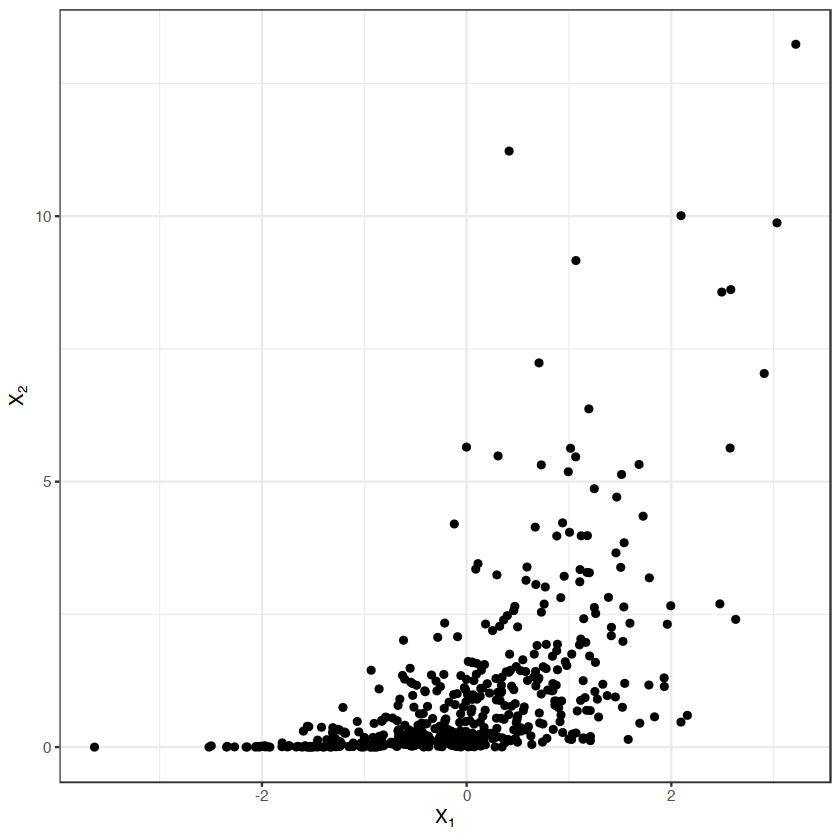

In [8]:
nc2d <- normalCopula(1/sqrt(2))
dist_ds2 <- mvdc(nc2d, c('norm', 'chisq'), list(list(mean=0, sd=1), list(df=1)))
scatterplot_mat(rMvdc(500, dist_ds2))

## Types of copulas and functions for constructing them
Copulas come in a variety of families, each with its own parameters that define the family and corresponding properties that depend on the family and the parameters.  

### Elliptical copulas
We have already used one of these families above, the _Elliptical_ family, which comes in two subtypes, the _Normal copula_, and the _t-copula_.  This family has a simple conceptual interpretation.  Take a multivariate normal or t-distribution with a specified correlation matrix and (for the t-distribution) degrees of freedom.  Transform this distribution to standard uniform margins, and that is your copula.

Elliptical copulas are generated using the `ellipCopula` function, or for normal copulas the `normalCopula` function, which is a wrapper around `ellipCopula` with the parameters set appropriately.  (One can also get a normal copula by setting the `df` parameter for a t-copula to `Inf`.)

By default, elliptical copulas are _exchangeable_, meaning that any two of the variables in the copula can be swapped without changing the copula.  Under this assumption there is necessarily only one correlation parameter.  This assumption can be relaxed using the `dispstr` argument (see the `ellipCopula` help file for details).  In this event several correlation values must be supplied for the correlation matrix.  In this example, we produce a completely unstructured 

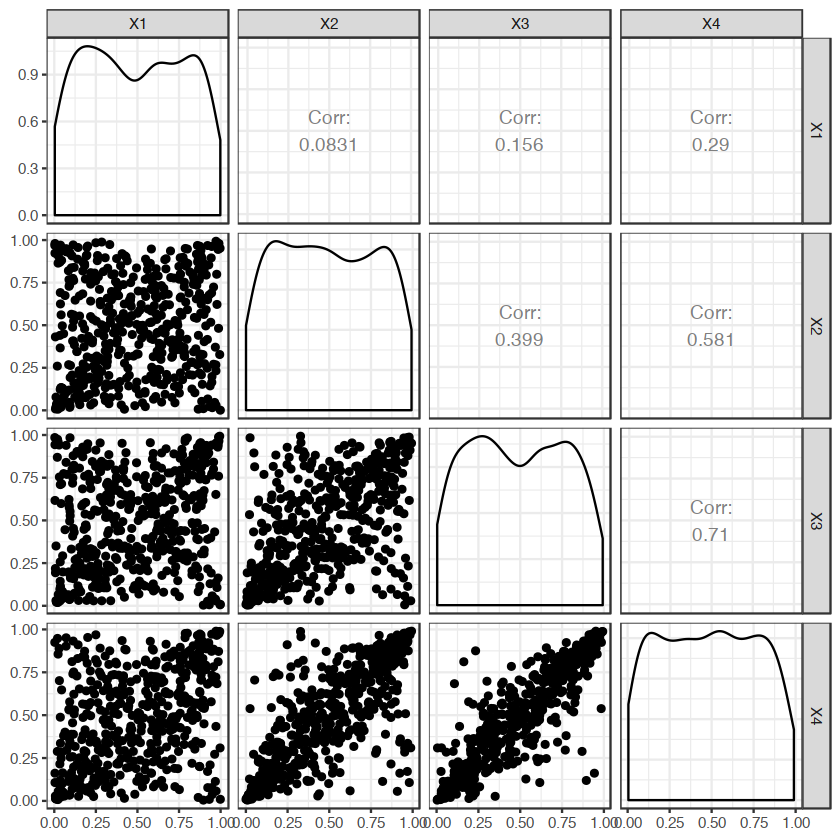

In [9]:
tcop4 <- ellipCopula('t', c(0.1, 0.2, 0.4, 0.6, 0.8, 0.9), dim=4, df=2, dispstr='un')
pairplot_mat(rCopula(500, tcop4))  # Reported "correlations" are actually Kendall's Tau values

The correlation coefficients are applied to the pairs of variables in column order in the grid above, so the $X_1$-$X_2$ gets the 0.1, and $X_3$-$X_4$ pair gets the 0.9.  The tail dependence coefficients are given in the same order below.  (Because the t-copula is radially symmetric, the corresponding upper and lower tail coefficients are equal.)

In [10]:
lambda(tcop4)

lower1    lower2    lower3    lower4    lower5    lower6    upper1    upper2 
0.2151699 0.2522155 0.3392541 0.4501849 0.6041813 0.7176856 0.2151699 0.2522155 
   upper3    upper4    upper5    upper6 
0.3392541 0.4501849 0.6041813 0.7176856

### Extreme value copulas
Extreme value (EV) copulas are of great theoretical importance because it describes the distribution of the block maxima of a set of variables.  There are several kinds of EV copulas, but for a given value of $\tau$, they are scarcely distinguishable from one another.  The `copula` package implements several of these, but of the ones implemented, only the Gumbel-Hougaard copula is currently implemented for $d > 2$.  Therefore, the GH is usually going to be the best choice when an EV copula is needed.

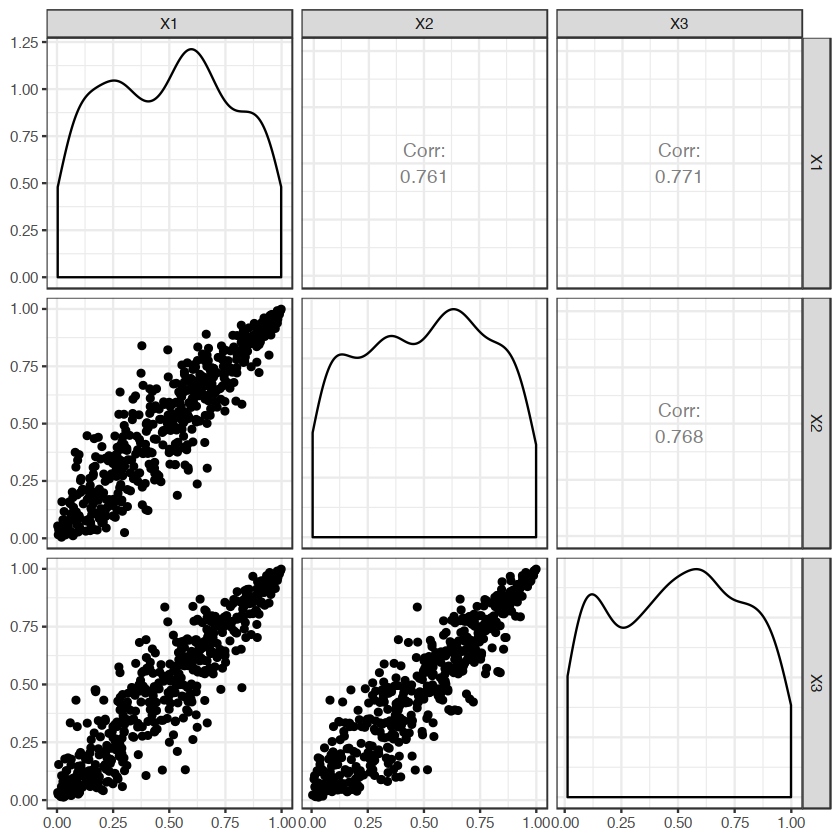

In [11]:
ghcop <- gumbelCopula(4, dim=3)
pairplot_mat(rCopula(500, ghcop))

### Copula family properties

Here is a summary of the properties of some of the more well known families of copulas.  For single-parameter families the parameter is conventionally called $\theta$.  Of the families listed below, only the elliptical copulas (Normal and t) have more than one parameter.

|Family | Notes | Constructor function|
|:------|:------|:--------|
|Normal | $\tau$ determined by correlation matrix.  Tail dependence is always zero, irrespective of $\tau$.| `normalCopula` (or `ellipCopula`)|
|t | $\tau$ determined by correlation matrix.  Tail dependence increases as degrees of freedom decreases. | `ellipCopula`|
| AMH | $\theta$ determines $\tau$.  Tail dependence is always zero. | `amhCopula` |
| Clayton | $\theta$ determines $\tau$ and $\lambda_l$.  $\lambda_u$ is always zero. | `claytonCopula`|
| Frank | $\theta$ determines $\tau$.  Tail dependence is always zero. | `frankCopula` |
| Gumbel-Hougaard| $\theta$ determines $\tau$ and $\lambda_u$.  $\lambda_l$ is always zero, and $\tau \geq 0$. | `gumbelCopula`|
| Joe | $\theta$ determines $\tau$ and $\lambda_u$.  $\lambda_l$ is always zero. | `joeCopula`|

### Mixtures and transformations

We can form a lot of other copulas through various transformations of the ones we've seen so far.  Copula _rotations_ are formed by flipping the direction of one or more of the variables in a copula.  Here we rotate $X_2$ in the Gumbel-Hougaard copula we just looked at.


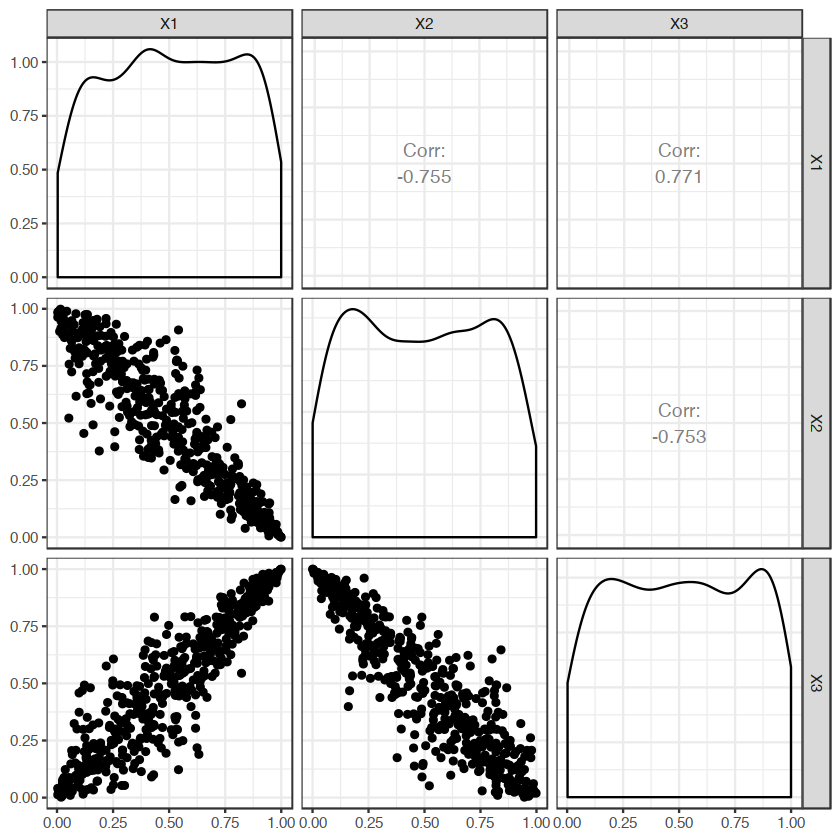

In [12]:
ghrotcop <- rotCopula(ghcop, c(FALSE, TRUE, FALSE))
pairplot_mat(rCopula(500, ghrotcop))

We can also create mixtures of copulas by forming linear combinations of other copulas.

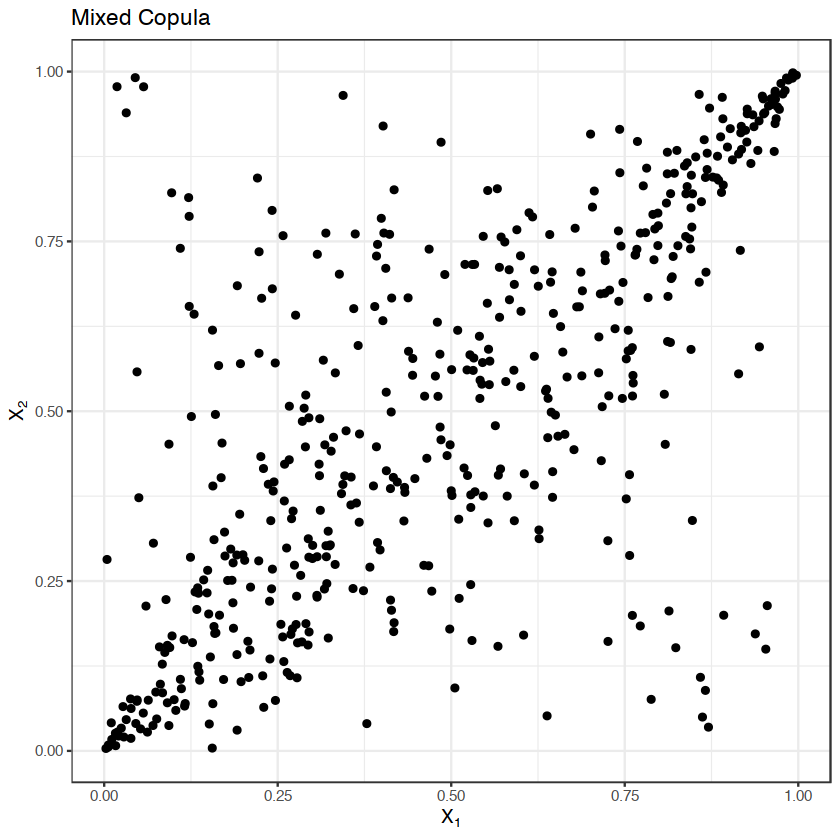

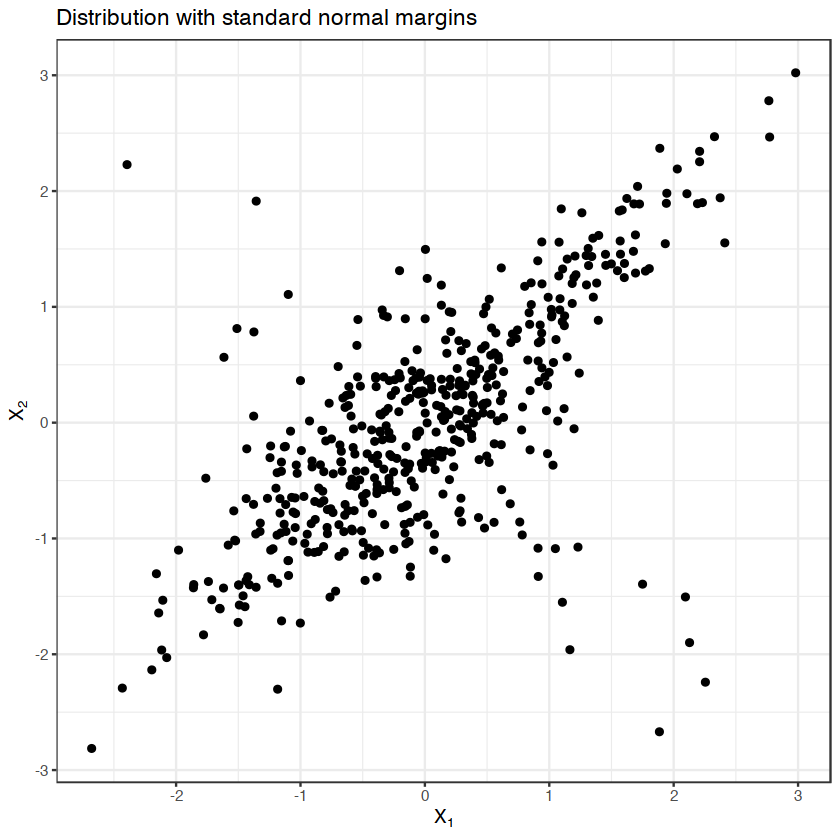

In [13]:
c1 <- ellipCopula('t', 0.5, dim=2, df=1)
c2 <- gumbelCopula(4, dim=2)
w <- c(0.5, 0.5)
mcop <- mixCopula(c(c1,c2), w)
scatterplot_mat(rCopula(500, mcop)) + ggtitle('Mixed Copula')
mdf <- mvdc(mcop, c('norm','norm'), list(list(mean=0, sd=1), list(mean=0, sd=1)))
scatterplot_mat(rMvdc(500, mdf)) + ggtitle('Distribution with standard normal margins')

Finally, we have the inscrutable Khoudraji's Device, which can create non-exchangeable copulas from pairs of exchangeable copulas.  Khoudraji's Device requires two copulas and a shape vector $s \in [0,1]^d$.  Often we take one of the two copulas to be the independence copula $\Pi$, but this is not required.  If either of the copula arguments to `khoudrajiCopula` is unspecified, it defaults to $\Pi$.

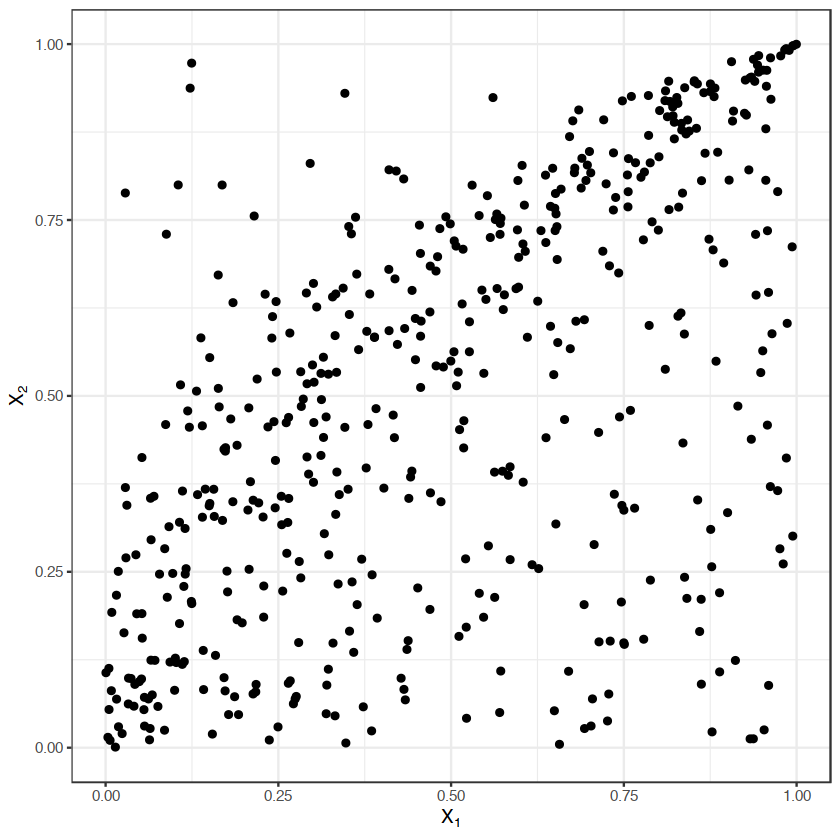

In [14]:
kc <- khoudrajiCopula(copula2 = gumbelCopula(4, dim=2), shape=c(0.5, 0.95))
scatterplot_mat(rCopula(500,kc))

Khoudraji's Device can give some very irregularly shaped copulas.  For example,

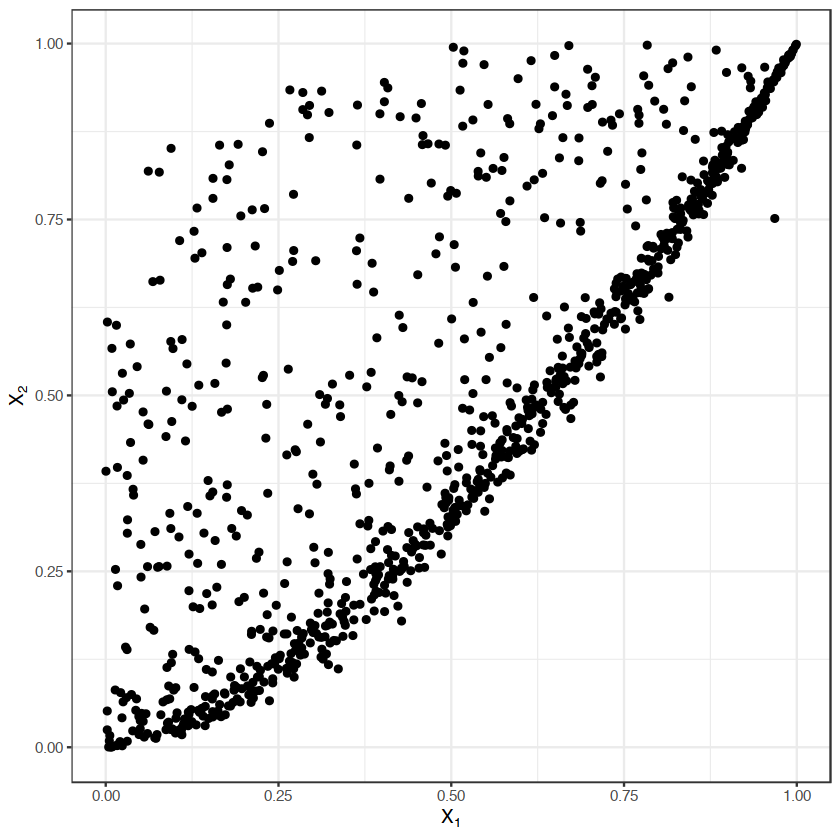

In [15]:
kc2 <- khoudrajiCopula(claytonCopula(iTau(claytonCopula(), 0.95)), gumbelCopula(iTau(gumbelCopula(), 0.95)), shape=c(0.95, 0.6))
scatterplot_mat(rCopula(1000, kc2))